# SM figure generation

## Setup

In [1]:
import re, json, sys
from pathlib import Path
from typing import Tuple

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib.ticker import MultipleLocator, AutoMinorLocator, ScalarFormatter
from PIL import Image
import numpy as np

# load internal functions
sys.path.append('../src')
from data_vis_utils import *

# top level data directory
data_dir = Path('../../data')
figure_dir = Path('../../figures/SM')

## FigS01 (aHPLC)

/var/folders/nr/f_s693214v54fjs9khpwyfnc0000gq/T/ipykernel_94766/852563376.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  A_4h['int_zero'] = A_4h['int_zero_no_blank']
/var/folders/nr/f_s693214v54fjs9khpwyfnc0000gq/T/ipykernel_94766/852563376.py:20: FutureWarning: Downcasting behavior in Series and DataFrame methods 'where', 'mask', and 'clip' is deprecated. In a future version this will not infer object dtypes or cast all-round floats to integers. Instead call result.infer_objects(copy=False) for object inference, or cast round floats explicitly. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_hplc.update(A_4h)
/Users/jc17773/anaconda3/envs/analysis_env/lib/python3.10/site-packages/seaborn/ax

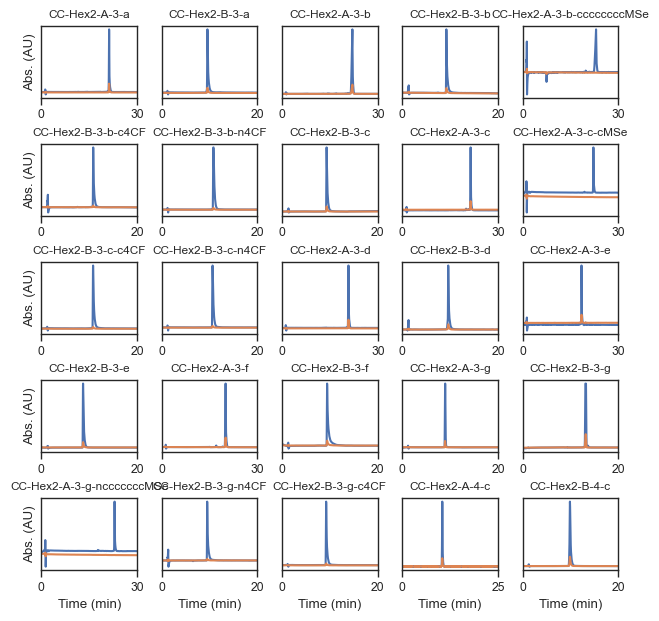

In [29]:
# get all of the HPLC data directories
hplc_dirs = sorted(data_dir.glob('**/01_hplc'))

df_lst = []
for hplc_dir in hplc_dirs:

    sample_files = sorted(hplc_dir.glob('*sample*.csv'))

    for sample_file in sample_files:

        date, peptide, wavelength, time = re.search('^(\d{8})_sample_(.+)_(\d{3})nm.+(\d{2}min)', sample_file.stem).groups()
        blank_file = next(sample_file.parent.glob(f'{date}_blank*{wavelength}nm*{time}*.csv'))
        df = read_hplc_csv(sample_file, blank_file, peptide, int(wavelength))
        df_lst.append(df)

df_hplc = pd.concat(df_lst, ignore_index=True)

A_4h = df_hplc.query('peptide == "CC-Hex2-A-4-c"')
A_4h['int_zero'] = A_4h['int_zero_no_blank']
df_hplc.update(A_4h)

sns.set(rc={"font.family":"Arial"}, style='ticks', context='paper')

g = sns.FacetGrid(data=df_hplc, col='peptide', col_wrap=5, sharex=False, sharey=False, height=1.26, aspect=1, hue='wavelength', hue_order=[220, 280], palette=sns.color_palette()[:2])
g.map(sns.lineplot, 't_min', 'int_zero', lw=1.5)

g.set_titles("{col_name}", size=8.5) 
g.set_axis_labels(x_var='Time (min)', y_var='Abs. (AU)')

for ax in g.axes.flat:
    pep = ax.get_title()

    _data = df_hplc.query('peptide == @pep')
    ax.set(
        yticks=[], 
        xlim=[0, _data['t_min'].max()], 
        xticks=[0, _data['t_min'].max()]) 

sns.despine(right=False, top=False)
plt.tight_layout(h_pad=0.5)
plt.savefig(figure_dir / 'S1.svg', transparent=True, format='svg')

## FigS02 (MALDI-MS)

In [61]:
# get all of the MS data directories
ms_dirs = sorted(data_dir.glob('**/02_maldi'))

df_ms_lst = []
for ms_dir in ms_dirs:
    for file in sorted(ms_dir.glob('*.txt')):
        df_ms = pd.read_csv(file, sep='\s', names=['m/z', 'int'], engine='python')
        df_ms['int_min_max'] = (df_ms['int'] - df_ms['int'].min()) / (df_ms['int'].max() - df_ms['int'].min())
        df_ms['peptide']  = re.search('\d{8}_(.+)_chca', file.stem).group(1)
        df_ms_lst.append(df_ms)
df_ms = pd.concat(df_ms_lst, ignore_index=True)

# read the peptide sequences CSV to get expected masses
seq_excel_path = data_dir / 'peptides_sequences.xlsx'

# read the csv
pep_seq_df = pd.read_excel(seq_excel_path).dropna()

# # use only 'name' and 'mass_Da' columns and rename
pep_seq_mass = pep_seq_df[['Name', 'Mass (Da)']]
pep_seq_mass.columns = ['peptide', 'exp_mass_Da']

# merge the dataframes
df_ms = pd.merge(df_ms, pep_seq_mass)

# group the peptide names for plotting
pep_groups = [
    ["CC-Hex2-A-3-a","CC-Hex2-B-3-a", 
     "CC-Hex2-A-3-b", "CC-Hex2-B-3-b",
     "CC-Hex2-A-3-b-cMSe", "CC-Hex2-B-3-b-c4CF",
    "CC-Hex2-B-3-b-n4CF", "CC-Hex2-A-3-c", 
    "CC-Hex2-B-3-c", "CC-Hex2-A-3-c-cMSe"], 
    ["CC-Hex2-B-3-c-n4CF", "CC-Hex2-B-3-c-c4CF",
    "CC-Hex2-A-4-c", "CC-Hex2-B-4-c", 
    "CC-Hex2-A-3-d", "CC-Hex2-B-3-d", 
    "CC-Hex2-A-3-e", "CC-Hex2-B-3-e", 
    "CC-Hex2-A-3-f","CC-Hex2-B-3-f"], 
    ["CC-Hex2-B-3-g", "CC-Hex2-A-3-g", 
     "CC-Hex2-B-3-g-n4CF", "CC-Hex2-A-3-g-nMSe",
     "CC-Hex2-B-3-g-c4CF"]
]

size = 3.1

for grp, j in zip(pep_groups, [0,10,20]):
    
    for i, peptide in enumerate(grp):

        sns.set(rc={'figure.figsize':[size, size/2]}, style='ticks', context='paper')

        fig, ax1 = plt.subplots()

        # These are in unitless percentages of the figure size. (0,0 is bottom left)
        if peptide in ['CC-Hex2-B-4-c', 'CC-Hex2-A-4-c']:
            left, bottom, width, height = [0.2, 0.4, 0.33, 0.35]
        else:
            left, bottom, width, height = [0.52, 0.4, 0.33, 0.35]
        ax2 = fig.add_axes([left, bottom, width, height])

        sns.lineplot(data=df_ms.query('peptide == @peptide'), x='m/z', y='int_min_max', color=sns.color_palette()[0], ax=ax1, lw=1.5, errorbar=None)
        ax1.set(
            yticks=[0,1], 
            ylim=[0,1.02],
            xlim=[1500, 4000], 
            xticks=[1500, 4000]
        )
        if i % 2 == 0:

            ax1.set_ylabel('Norm. Int.')

            if i == len(grp)-2:
                ax1.set_xlabel('m/z')
            else:
                ax1.set(xticklabels=[], xlabel='')
        else:

            ax1.set(ylabel='', yticklabels=[])

            if i == len(grp)-1:
                ax1.set_xlabel('m/z')
            else:
                ax1.set(xticklabels=[], xlabel='')

        ax2.plot(range(6)[::-1], color='green')

        sns.lineplot(
            data=df_ms.query('peptide == @peptide'),
            x='m/z',
            y='int_min_max',
            color=sns.color_palette()[0],
            lw=1,
            ax=ax2,
            errorbar=None
        )

        exp_mass = df_ms.query('peptide == @peptide')['exp_mass_Da'].iloc[0]
        ax2.set(
            ylabel='',
            xlabel='',
            yticks=[], 
            ylim=[0,1.05],
            xlim=[exp_mass-50, exp_mass+50], 
            xticks=list(map(int, np.linspace(exp_mass-50, exp_mass+50,3)))
        )

        width = 1.5
        ax1.set_title(peptide)

        for ax in [ax1, ax2]:

            # Set the spine thickness
            for spine in ax.spines.values():
                spine.set_linewidth(width)  # Set the desired thickness

        plt.savefig(
            figure_dir / f'S02/{i+j:02}_{peptide}.png',
            dpi=150, 
            transparent=True,
            bbox_inches='tight'
        )

        plt.close()


## FigS03 (CD scans)

/Users/jc17773/anaconda3/envs/analysis_env/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/var/folders/nr/f_s693214v54fjs9khpwyfnc0000gq/T/ipykernel_18263/1271184536.py:50: UserWarning: The figure layout has changed to tight
  plt.tight_layout(h_pad=0.5)


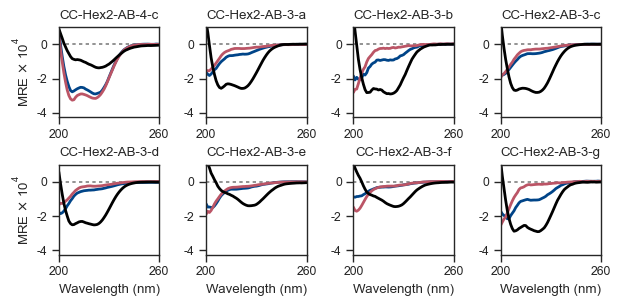

In [3]:
cd_paths = data_dir.glob('*/03_cd/routine/*.txt')

cd_dfs = [CircularDiochroismFunctions.make_cd_df(p) for p in cd_paths]
cd_df = pd.concat(cd_dfs, ignore_index=True).fillna(0)

# Filter the blank data
blank_data = cd_df[cd_df['type'] == 'blank']

# Apply the subtraction function to the original DataFrame
cd_df['abs_zero_mdeg'] = cd_df.apply(
    CircularDiochroismFunctions.subtract_blank, 
    args=[blank_data], 
    axis=1
)

# Apply the wrapper function to calculate MRE for each row
cd_df['mre'] = cd_df.apply(CircularDiochroismFunctions.calc_mre_row, axis=1)

# Extract the register from each of the sequences to group
cd_df['assembly'] = cd_df['related_id'].str.extract('([34]-[abcdefg])')
cd_df['peptide_type'] = cd_df['related_id'].apply(CircularDiochroismFunctions.determine_pep_type)

col_order = ['4-c', '3-a', '3-b', '3-c', '3-d', '3-e', '3-f', '3-g']

sns.set(rc={"font.family":"Arial"}, style='ticks', context='paper')

g = sns.FacetGrid(data=cd_df.query('type=="pre" and wavelength_nm >= 200'), col='assembly', col_wrap=4, height=1.575, aspect=1, col_order=col_order, hue='peptide_type', sharex=False, sharey=False, hue_order=['A','B', 'AB'], palette=['#004488', '#bb5566', 'black'],)
g.map(sns.lineplot, 'wavelength_nm', 'mre', lw=2)

g.set_titles("{col_name}") 
g.set_axis_labels(x_var='Wavelength (nm)', y_var=r'MRE $\times$ 10$\regular{^4}$')

titles = ['CC-Hex2-AB-4-c', 'CC-Hex2-AB-3-a', 'CC-Hex2-AB-3-b', 'CC-Hex2-AB-3-c', 'CC-Hex2-AB-3-d', 'CC-Hex2-AB-3-e', 'CC-Hex2-AB-3-f', 'CC-Hex2-AB-3-g']

for i, ax in enumerate(g.axes.flat):

    ax.set_title(titles[i])

    ax.set(
        xlim=[200,260],
        ylim=[-42_500, 10_000],
        yticks = [0, -20_000, -40_000],
        yticklabels=[0, -2, -4],
        xticks=[200,260],
    )

    ax.axhline(0, dashes=(2,2), color='.5', zorder=0)

sns.despine(right=False, top=False)
plt.tight_layout(h_pad=0.5)
plt.savefig(figure_dir / 'S3.svg', transparent=True, format='svg')

## FigS04 (CD melts)

/Users/jc17773/anaconda3/envs/analysis_env/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/var/folders/nr/f_s693214v54fjs9khpwyfnc0000gq/T/ipykernel_18263/3650688205.py:49: UserWarning: The figure layout has changed to tight
  plt.tight_layout(h_pad=0.5)


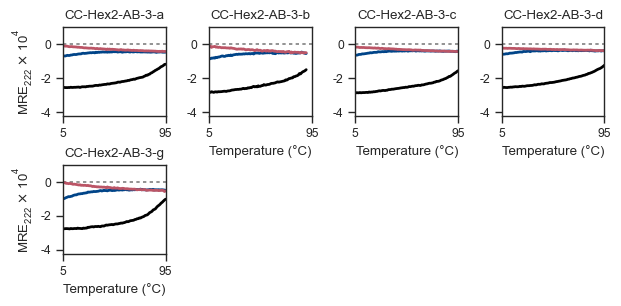

In [5]:
cd_paths = data_dir.glob('*/03_cd/routine/*.txt')

cd_dfs = [CircularDiochroismFunctions.make_cd_df(p) for p in cd_paths]
cd_df = pd.concat(cd_dfs, ignore_index=True).fillna(0)

# Filter the blank data
blank_data = cd_df[cd_df['type'] == 'blank']

# Apply the subtraction function to the original DataFrame
cd_df['abs_zero_mdeg'] = cd_df.apply(
    CircularDiochroismFunctions.subtract_blank, 
    args=[blank_data], 
    axis=1
)

# Apply the wrapper function to calculate MRE for each row
cd_df['mre'] = cd_df.apply(CircularDiochroismFunctions.calc_mre_row, axis=1)

# Extract the register from each of the sequences to group
cd_df['register'] = cd_df['related_id'].str.extract('3-([abcdg])')
cd_df['peptide_type'] = cd_df['related_id'].apply(CircularDiochroismFunctions.determine_pep_type)

col_order = list('abcdg')

sns.set(rc={"font.family":"Arial"}, style='ticks', context='paper')

g = sns.FacetGrid(data=cd_df.query('type=="melt"'), col='register', col_wrap=4, height=6.3/4, aspect=1, col_order=col_order, hue='peptide_type', sharex=False, sharey=False, hue_order=['A','B', 'AB'], palette=['#004488', '#bb5566', 'black'])
g.map(sns.lineplot, 'T_C', 'mre', lw=2)

g.set_axis_labels(x_var='Temperature (°C)', y_var=r'MRE$\regular{_{222}}$ $\times$ 10$\regular{^4}$')

titles = ['CC-Hex2-AB-3-a', 'CC-Hex2-AB-3-b', 'CC-Hex2-AB-3-c', 'CC-Hex2-AB-3-d', 'CC-Hex2-AB-3-g']

for i, ax in enumerate(g.axes.flat):

    ax.set_title(titles[i])

    ax.set(
        ylim=[-42_500, 10_000],
        yticks = [0, -20_000, -40_000],
        yticklabels=[0, -2, -4],
        xlim=[5,95],
        xticks=[5,95],
    )

    ax.axhline(0, dashes=(2,2), color='.5', zorder=0)

sns.despine(right=False, top=False)
plt.tight_layout(h_pad=0.5)
plt.savefig(figure_dir / 'S4.svg', transparent=True, format='svg')

## FigS05 (quench variants CD)

/Users/jc17773/anaconda3/envs/analysis_env/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/var/folders/nr/f_s693214v54fjs9khpwyfnc0000gq/T/ipykernel_18263/299384083.py:58: UserWarning: The figure layout has changed to tight
  plt.tight_layout(h_pad=0.5)


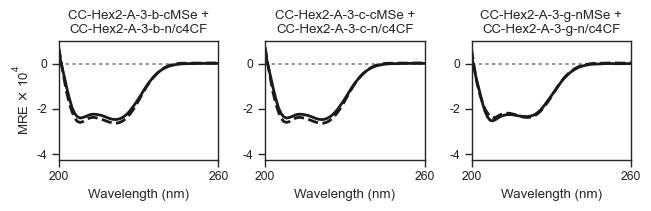

In [7]:
quench_cd_paths = data_dir.glob('*/03_cd/Mse_CNF_variants/*.txt')

cd_dfs = [CircularDiochroismFunctions.make_cd_df(p) for p in quench_cd_paths]
cd_df = pd.concat(cd_dfs, ignore_index=True).fillna(0)

# Filter the blank data
blank_data = cd_df[cd_df['type'] == 'blank']

# Apply the subtraction function to the original DataFrame
cd_df['abs_zero_mdeg'] = cd_df.apply(
    CircularDiochroismFunctions.subtract_blank, 
    args=[blank_data], 
    axis=1
)

# Apply the wrapper function to calculate MRE for each row
cd_df['mre'] = cd_df.apply(CircularDiochroismFunctions.calc_mre_row, axis=1)
  
cd_df['CNF_type'] = cd_df['related_id'].apply(CircularDiochroismFunctions.determine_cnf_type)
cd_df['register'] = cd_df['related_id'].str.extract('3-([bcg])')

sns.set(rc={"font.family":"Arial"}, style='ticks', context='paper')

g = sns.FacetGrid(
    data=cd_df.query('type=="pre" and wavelength_nm >= 200'), 
    col='register',
    col_order=['b', 'c', 'g'], 
    col_wrap=3, 
    height=2.2, 
    aspect=1, 
    sharex=False, 
    sharey=False,
    hue='CNF_type', 
    hue_order=['n4CF','c4CF'], hue_kws={'color': ['k', 'k'], "ls" : ["-","--"]}
)

g.map(sns.lineplot, 'wavelength_nm', 'mre', lw=2)

g.set_axis_labels(x_var='Wavelength (nm)', y_var=r'MRE $\times$ 10$\regular{^4}$')

titles = ['CC-Hex2-A-3-b-cMSe +\nCC-Hex2-A-3-b-n/c4CF', 'CC-Hex2-A-3-c-cMSe +\nCC-Hex2-A-3-c-n/c4CF', 'CC-Hex2-A-3-g-nMSe +\nCC-Hex2-A-3-g-n/c4CF']

for i, ax in enumerate(g.axes.flat):

    ax.set_title(titles[i])

    ax.set(
        xlim=[200,260],
        ylim=[-42_500, 10_000],
        yticks = [0, -20_000, -40_000],
        yticklabels=[0, -2, -4],
        xticks=[200,260],
    )

    ax.axhline(0, dashes=(2,2), color='.5', zorder=0)

sns.despine(right=False, top=False)
plt.tight_layout(h_pad=0.5)
plt.savefig(figure_dir / 'S5.svg', transparent=True, format='svg')

## FigS06 (b-reg jobplot)

/var/folders/nr/f_s693214v54fjs9khpwyfnc0000gq/T/ipykernel_94766/1947045250.py:99: UserWarning: FixedFormatter should only be used together with FixedLocator
  jobplot_ht_ax.set_xticklabels(['60:0', '50:10', '40:20', '30:30', '20:40', '50:10', '0:60'], rotation=-45)


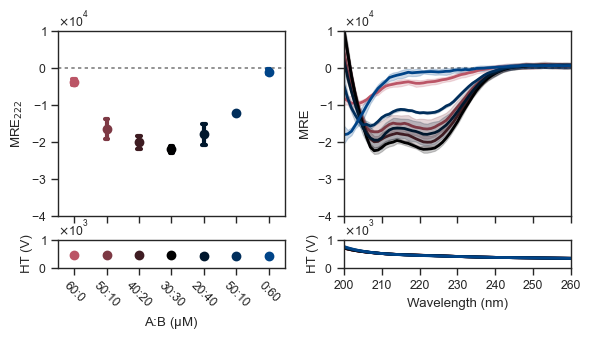

In [56]:
jobplot_dir = data_dir / 'CC-Hex2-AB-3-b' / '03_cd' / 'jobplot'
jobplot_paths = sorted(jobplot_dir.glob('*.txt'))

jobplot_dfs = [CircularDiochroismFunctions.make_cd_df(p) for p in jobplot_paths]
jobplot_df = pd.concat(jobplot_dfs, ignore_index=True).fillna(0)

# Filter the blank data
blank_data = jobplot_df[jobplot_df['type'] == 'blank']

# Apply the subtraction function to the original DataFrame
jobplot_df['abs_zero_mdeg'] = jobplot_df.apply(
    CircularDiochroismFunctions.subtract_blank, 
    args=[blank_data], 
    axis=1
)

# Apply the wrapper function to calculate MRE for each row
jobplot_df['mre'] = jobplot_df.apply(CircularDiochroismFunctions.calc_mre_row, axis=1)

# Make ratio id
jobplot_df['ratio'] = jobplot_df['conc_uM_1'].astype(str) + "_" + jobplot_df['conc_uM_2'].astype(str)

# List of unique labels in the order you want them to appear
label_order = [
    '60.0_0.0', '50.0_10.0', '40.0_20.0', '30.0_30.0', 
    '20.0_40.0', '10.0_50.0', '0.0_60.0'
]

# Convert the 'labels' column to a categorical data type with the given order
jobplot_df['ratio'] = pd.Categorical(jobplot_df['ratio'], categories=label_order, ordered=True)

# Sort the DataFrame based on the 'labels' column
jobplot_df = jobplot_df.sort_values('ratio')

from matplotlib.ticker import ScalarFormatter

sns.set(rc={'figure.figsize':[6,3.5], "font.family":"Arial"}, style='ticks', context='paper')

jobplot_ax = plt.subplot2grid((5,2),(0,0), rowspan=4)
jobplot_ht_ax = plt.subplot2grid((5,2),(4,0))
spectrum_ax = plt.subplot2grid((5,2),(0,1), rowspan=4)
spectrum_ht_ax = plt.subplot2grid((5,2),(4,1))

# List of unique labels in the order you want them to appear
label_order = ['60.0_0.0', '50.0_10.0', '40.0_20.0', '30.0_30.0', '20.0_40.0', '10.0_50.0', '0.0_60.0']

# Convert the 'labels' column to a categorical data type with the given order
jobplot_df['ratio'] = pd.Categorical(jobplot_df['ratio'], categories=label_order, ordered=True)


custom_palette = sns.blend_palette(['#bb5566', 'black', '#004488'], n_colors=7)

sns.set(rc={'figure.figsize':[3,3], "font.family":"Arial"}, style='ticks', context='paper')
sns.pointplot(
    data = jobplot_df.query('wavelength_nm==222'),
    x='ratio', 
    y='mre', 
    hue='ratio', 
    errorbar='sd',
    palette=custom_palette,
    capsize=0.1,
    err_kws={'linewidth': 3},
    ax=jobplot_ax
)
jobplot_ax.get_legend().remove()
jobplot_ax.set(
    xlabel=r'',
    ylabel=r'MRE$_{222}$',
    xticklabels=[],
    ylim=[-40_000, 10_000],
)

jobplot_ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
jobplot_ax.ticklabel_format(axis='y', style='scientific', scilimits=(-2, 2))
jobplot_ax.axhline(0, dashes=(2,2), color='.5', zorder=0)

sns.pointplot(
    data = jobplot_df.query('wavelength_nm==222'),
    x='ratio', 
    y='ht_V', 
    hue='ratio', 
    errorbar='sd',
    palette=custom_palette,
    capsize=0.1,
    err_kws={'linewidth': 3},
    ax=jobplot_ht_ax
)
jobplot_ht_ax.get_legend().remove()
jobplot_ht_ax.set(
    ylim=[0, 1_000],
    xlabel=r'A:B ($\regular{\mu}M$)',
    ylabel='HT (V)',
)

jobplot_ht_ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
jobplot_ht_ax.ticklabel_format(axis='y', style='scientific', scilimits=(-2, 2))


jobplot_ht_ax.set_xticklabels(['60:0', '50:10', '40:20', '30:30', '20:40', '50:10', '0:60'], rotation=-45)

sns.lineplot(data=jobplot_df.query('type=="pre"'), x='wavelength_nm', y='mre', legend=None, hue='ratio', ax=spectrum_ax, style='type', lw=2, palette=custom_palette, errorbar='sd')
sns.lineplot(data=jobplot_df.query('type=="pre"'), x='wavelength_nm', y='ht_V', legend=None, hue='ratio', ax=spectrum_ht_ax, style='type', lw=2, palette=custom_palette, errorbar='sd')

spectrum_ax.set(
    xlim=[200,260],
    ylim=[-40_000, 10_000],
    xticklabels=[],
    xlabel='',
    ylabel='MRE',
)
spectrum_ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
spectrum_ax.ticklabel_format(axis='y', style='scientific', scilimits=(-2, 2))
spectrum_ax.axhline(0, dashes=(2,2), color='.5', zorder=0)

spectrum_ht_ax.set(
    xlim=[200,260],
    ylim=[0, 1_000],
    xlabel='Wavelength (nm)',
    ylabel='HT (V)',
)

spectrum_ht_ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
spectrum_ht_ax.ticklabel_format(axis='y', style='scientific', scilimits=(-2, 2))

plt.tight_layout(h_pad=-0.4)
plt.savefig(figure_dir / 'S6.svg', transparent=True, format='svg')


## FigS07 (c-reg jobplot)

/var/folders/nr/f_s693214v54fjs9khpwyfnc0000gq/T/ipykernel_94766/589315865.py:99: UserWarning: FixedFormatter should only be used together with FixedLocator
  jobplot_ht_ax.set_xticklabels(['60:0', '50:10', '40:20', '30:30', '20:40', '50:10', '0:60'], rotation=-45)


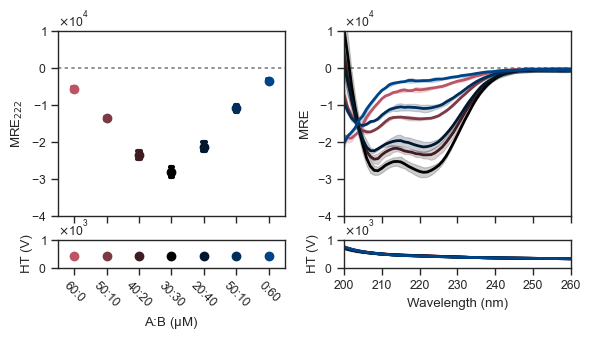

In [54]:
jobplot_dir = data_dir / 'CC-Hex2-AB-3-c' / '03_cd' / 'jobplot'
jobplot_paths = sorted(jobplot_dir.glob('*.txt'))

jobplot_dfs = [CircularDiochroismFunctions.make_cd_df(p) for p in jobplot_paths]
jobplot_df = pd.concat(jobplot_dfs, ignore_index=True).fillna(0)

# Filter the blank data
blank_data = jobplot_df[jobplot_df['type'] == 'blank']

# Apply the subtraction function to the original DataFrame
jobplot_df['abs_zero_mdeg'] = jobplot_df.apply(
    CircularDiochroismFunctions.subtract_blank, 
    args=[blank_data], 
    axis=1
)

# Apply the wrapper function to calculate MRE for each row
jobplot_df['mre'] = jobplot_df.apply(CircularDiochroismFunctions.calc_mre_row, axis=1)

# Make ratio id
jobplot_df['ratio'] = jobplot_df['conc_uM_1'].astype(str) + "_" + jobplot_df['conc_uM_2'].astype(str)

# List of unique labels in the order you want them to appear
label_order = [
    '60.0_0.0', '50.0_10.0', '40.0_20.0', '30.0_30.0', 
    '20.0_40.0', '10.0_50.0', '0.0_60.0'
]

# Convert the 'labels' column to a categorical data type with the given order
jobplot_df['ratio'] = pd.Categorical(jobplot_df['ratio'], categories=label_order, ordered=True)

# Sort the DataFrame based on the 'labels' column
jobplot_df = jobplot_df.sort_values('ratio')

from matplotlib.ticker import ScalarFormatter

sns.set(rc={'figure.figsize':[6,3.5], "font.family":"Arial"}, style='ticks', context='paper')

jobplot_ax = plt.subplot2grid((5,2),(0,0), rowspan=4)
jobplot_ht_ax = plt.subplot2grid((5,2),(4,0))
spectrum_ax = plt.subplot2grid((5,2),(0,1), rowspan=4)
spectrum_ht_ax = plt.subplot2grid((5,2),(4,1))

# List of unique labels in the order you want them to appear
label_order = ['60.0_0.0', '50.0_10.0', '40.0_20.0', '30.0_30.0', '20.0_40.0', '10.0_50.0', '0.0_60.0']

# Convert the 'labels' column to a categorical data type with the given order
jobplot_df['ratio'] = pd.Categorical(jobplot_df['ratio'], categories=label_order, ordered=True)


custom_palette = sns.blend_palette(['#bb5566', 'black', '#004488'], n_colors=7)

sns.set(rc={'figure.figsize':[3,3], "font.family":"Arial"}, style='ticks', context='paper')
sns.pointplot(
    data = jobplot_df.query('wavelength_nm==222'),
    x='ratio', 
    y='mre', 
    hue='ratio', 
    errorbar='sd',
    palette=custom_palette,
    capsize=0.1,
    err_kws={'linewidth': 3},
    ax=jobplot_ax
)
jobplot_ax.get_legend().remove()
jobplot_ax.set(
    xlabel=r'',
    ylabel=r'MRE$_{222}$',
    xticklabels=[],
    ylim=[-40_000, 10_000],
)

jobplot_ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
jobplot_ax.ticklabel_format(axis='y', style='scientific', scilimits=(-2, 2))
jobplot_ax.axhline(0, dashes=(2,2), color='.5', zorder=0)

sns.pointplot(
    data = jobplot_df.query('wavelength_nm==222'),
    x='ratio', 
    y='ht_V', 
    hue='ratio', 
    errorbar='sd',
    palette=custom_palette,
    capsize=0.1,
    err_kws={'linewidth': 3},
    ax=jobplot_ht_ax
)
jobplot_ht_ax.get_legend().remove()
jobplot_ht_ax.set(
    ylim=[0, 1_000],
    xlabel=r'A:B ($\regular{\mu}M$)',
    ylabel='HT (V)',
)

jobplot_ht_ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
jobplot_ht_ax.ticklabel_format(axis='y', style='scientific', scilimits=(-2, 2))


jobplot_ht_ax.set_xticklabels(['60:0', '50:10', '40:20', '30:30', '20:40', '50:10', '0:60'], rotation=-45)

sns.lineplot(data=jobplot_df.query('type=="pre"'), x='wavelength_nm', y='mre', legend=None, hue='ratio', ax=spectrum_ax, style='type', lw=2, palette=custom_palette, errorbar='sd')
sns.lineplot(data=jobplot_df.query('type=="pre"'), x='wavelength_nm', y='ht_V', legend=None, hue='ratio', ax=spectrum_ht_ax, style='type', lw=2, palette=custom_palette, errorbar='sd')

spectrum_ax.set(
    xlim=[200,260],
    ylim=[-40_000, 10_000],
    xticklabels=[],
    xlabel='',
    ylabel='MRE',
)
spectrum_ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
spectrum_ax.ticklabel_format(axis='y', style='scientific', scilimits=(-2, 2))
spectrum_ax.axhline(0, dashes=(2,2), color='.5', zorder=0)

spectrum_ht_ax.set(
    xlim=[200,260],
    ylim=[0, 1_000],
    xlabel='Wavelength (nm)',
    ylabel='HT (V)',
)

spectrum_ht_ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
spectrum_ht_ax.ticklabel_format(axis='y', style='scientific', scilimits=(-2, 2))

plt.tight_layout(h_pad=-0.4)
plt.savefig(figure_dir / 'S7.svg', transparent=True, format='svg')


## FigS08 (g-reg jobplot)

/var/folders/nr/f_s693214v54fjs9khpwyfnc0000gq/T/ipykernel_94766/3767561246.py:99: UserWarning: FixedFormatter should only be used together with FixedLocator
  jobplot_ht_ax.set_xticklabels(['60:0', '50:10', '40:20', '30:30', '20:40', '50:10', '0:60'], rotation=-45)


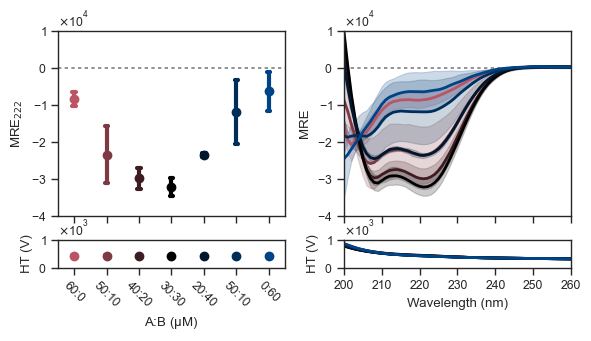

In [53]:
jobplot_dir = data_dir / 'CC-Hex2-AB-3-g' / '03_cd' / 'jobplot'
jobplot_paths = sorted(jobplot_dir.glob('*.txt'))

jobplot_dfs = [CircularDiochroismFunctions.make_cd_df(p) for p in jobplot_paths]
jobplot_df = pd.concat(jobplot_dfs, ignore_index=True).fillna(0)

# Filter the blank data
blank_data = jobplot_df[jobplot_df['type'] == 'blank']

# Apply the subtraction function to the original DataFrame
jobplot_df['abs_zero_mdeg'] = jobplot_df.apply(
    CircularDiochroismFunctions.subtract_blank, 
    args=[blank_data], 
    axis=1
)

# Apply the wrapper function to calculate MRE for each row
jobplot_df['mre'] = jobplot_df.apply(CircularDiochroismFunctions.calc_mre_row, axis=1)

# Make ratio id
jobplot_df['ratio'] = jobplot_df['conc_uM_1'].astype(str) + "_" + jobplot_df['conc_uM_2'].astype(str)

# List of unique labels in the order you want them to appear
label_order = [
    '60.0_0.0', '50.0_10.0', '40.0_20.0', '30.0_30.0', 
    '20.0_40.0', '10.0_50.0', '0.0_60.0'
]

# Convert the 'labels' column to a categorical data type with the given order
jobplot_df['ratio'] = pd.Categorical(jobplot_df['ratio'], categories=label_order, ordered=True)

# Sort the DataFrame based on the 'labels' column
jobplot_df = jobplot_df.sort_values('ratio')

from matplotlib.ticker import ScalarFormatter

sns.set(rc={'figure.figsize':[6,3.5], "font.family":"Arial"}, style='ticks', context='paper')

jobplot_ax = plt.subplot2grid((5,2),(0,0), rowspan=4)
jobplot_ht_ax = plt.subplot2grid((5,2),(4,0))
spectrum_ax = plt.subplot2grid((5,2),(0,1), rowspan=4)
spectrum_ht_ax = plt.subplot2grid((5,2),(4,1))

# List of unique labels in the order you want them to appear
label_order = ['60.0_0.0', '50.0_10.0', '40.0_20.0', '30.0_30.0', '20.0_40.0', '10.0_50.0', '0.0_60.0']

# Convert the 'labels' column to a categorical data type with the given order
jobplot_df['ratio'] = pd.Categorical(jobplot_df['ratio'], categories=label_order, ordered=True)


custom_palette = sns.blend_palette(['#bb5566', 'black', '#004488'], n_colors=7)

sns.set(rc={'figure.figsize':[3,3], "font.family":"Arial"}, style='ticks', context='paper')
sns.pointplot(
    data = jobplot_df.query('wavelength_nm==222'),
    x='ratio', 
    y='mre', 
    hue='ratio', 
    errorbar='sd',
    palette=custom_palette,
    capsize=0.1,
    err_kws={'linewidth': 3},
    ax=jobplot_ax
)
jobplot_ax.get_legend().remove()
jobplot_ax.set(
    xlabel=r'',
    ylabel=r'MRE$_{222}$',
    xticklabels=[],
    ylim=[-40_000, 10_000],
)

jobplot_ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
jobplot_ax.ticklabel_format(axis='y', style='scientific', scilimits=(-2, 2))
jobplot_ax.axhline(0, dashes=(2,2), color='.5', zorder=0)

sns.pointplot(
    data = jobplot_df.query('wavelength_nm==222'),
    x='ratio', 
    y='ht_V', 
    hue='ratio', 
    errorbar='sd',
    palette=custom_palette,
    capsize=0.1,
    err_kws={'linewidth': 3},
    ax=jobplot_ht_ax
)
jobplot_ht_ax.get_legend().remove()
jobplot_ht_ax.set(
    ylim=[0, 1_000],
    xlabel=r'A:B ($\regular{\mu}M$)',
    ylabel='HT (V)',
)

jobplot_ht_ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
jobplot_ht_ax.ticklabel_format(axis='y', style='scientific', scilimits=(-2, 2))


jobplot_ht_ax.set_xticklabels(['60:0', '50:10', '40:20', '30:30', '20:40', '50:10', '0:60'], rotation=-45)

sns.lineplot(data=jobplot_df.query('type=="pre"'), x='wavelength_nm', y='mre', legend=None, hue='ratio', ax=spectrum_ax, style='type', lw=2, palette=custom_palette, errorbar='sd')
sns.lineplot(data=jobplot_df.query('type=="pre"'), x='wavelength_nm', y='ht_V', legend=None, hue='ratio', ax=spectrum_ht_ax, style='type', lw=2, palette=custom_palette, errorbar='sd')

spectrum_ax.set(
    xlim=[200,260],
    ylim=[-40_000, 10_000],
    xticklabels=[],
    xlabel='',
    ylabel='MRE',
)
spectrum_ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
spectrum_ax.ticklabel_format(axis='y', style='scientific', scilimits=(-2, 2))
spectrum_ax.axhline(0, dashes=(2,2), color='.5', zorder=0)

spectrum_ht_ax.set(
    xlim=[200,260],
    ylim=[0, 1_000],
    xlabel='Wavelength (nm)',
    ylabel='HT (V)',
)

spectrum_ht_ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
spectrum_ht_ax.ticklabel_format(axis='y', style='scientific', scilimits=(-2, 2))

plt.tight_layout(h_pad=-0.4)
plt.savefig(figure_dir / 'S8.svg', transparent=True, format='svg')


In [13]:
import numpy as np


cd_df = cd_df.fillna(0)

#  Step 1: Create the 'ratio' column in both DataFrames
cd_df['ratio'] = cd_df['conc_uM_1'].astype(str) + "_" + cd_df['conc_uM_2'].astype(str)
cd_df_subset = cd_df.query(f'related_id == "CCHex2B-{peptide[-1]}"')
cd_df_subset['ratio'] = cd_df_subset['conc_uM_2'].astype(str) + "_" + cd_df_subset['conc_uM_1'].astype(str)

# Step 2: Replace the values in cd_df with the values in cd_df_subset based on their index
cd_df.update(cd_df_subset)

# List of unique labels in the order you want them to appear
label_order = ['60.0_0.0', '50.0_10.0', '40.0_20.0', '30.0_30.0', '20.0_40.0', '10.0_50.0', '0.0_60.0']

# Convert the 'labels' column to a categorical data type with the given order
cd_df['ratio'] = pd.Categorical(cd_df['ratio'], categories=label_order, ordered=True)

cd_df['ratio'].unique()

[NaN]
Categories (7, object): ['60.0_0.0' < '50.0_10.0' < '40.0_20.0' < '30.0_30.0' < '20.0_40.0' < '10.0_50.0' < '0.0_60.0']

/var/folders/nr/f_s693214v54fjs9khpwyfnc0000gq/T/ipykernel_54956/812441648.py:20: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.pointplot(
/var/folders/nr/f_s693214v54fjs9khpwyfnc0000gq/T/ipykernel_54956/812441648.py:20: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  sns.pointplot(
/var/folders/nr/f_s693214v54fjs9khpwyfnc0000gq/T/ipykernel_54956/812441648.py:20: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 3}` instead.

  sns.pointplot(


TypeError: 'NoneType' object is not iterable

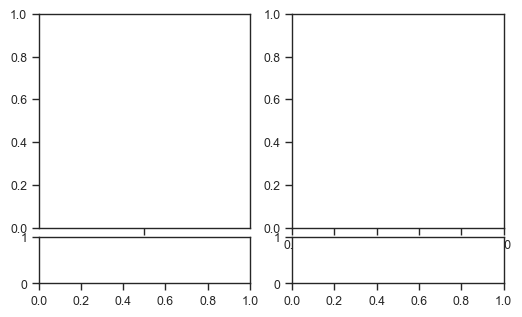

In [14]:

from matplotlib.ticker import ScalarFormatter

sns.set(rc={'figure.figsize':[6,3.5], "font.family":"Arial"}, style='ticks', context='paper')

jobplot_ax = plt.subplot2grid((5,2),(0,0), rowspan=4)
jobplot_ht_ax = plt.subplot2grid((5,2),(4,0))
spectrum_ax = plt.subplot2grid((5,2),(0,1), rowspan=4)
spectrum_ht_ax = plt.subplot2grid((5,2),(4,1))

# List of unique labels in the order you want them to appear
label_order = ['60.0_0.0', '50.0_10.0', '40.0_20.0', '30.0_30.0', '20.0_40.0', '10.0_50.0', '0.0_60.0']

# Convert the 'labels' column to a categorical data type with the given order
cd_df['ratio'] = pd.Categorical(cd_df['ratio'], categories=label_order, ordered=True)


custom_palette = sns.blend_palette(['#bb5566', 'black', '#004488'], n_colors=7)

sns.set(rc={'figure.figsize':[3,3], "font.family":"Arial"}, style='ticks', context='paper')
sns.pointplot(
    data = cd_df.query('wavelength_nm==222'),
    x='ratio', 
    y='mre', 
    hue='ratio', 
    errorbar='sd',
    palette=custom_palette,
    scale=1.2,
    capsize=0.1,
    errwidth=3,
    ax=jobplot_ax
)
jobplot_ax.get_legend().remove()
jobplot_ax.set(
    xlabel=r'',
    ylabel=r'MRE$_{222}$', #' \n'+r'(deg cm$\regular{^2}$ dmol$\regular{^{-1}}$ res$\regular{^{-1}}$ $\regular{\times}$ 10$\regular{^3}$)'
    xticklabels=[],
    ylim=[-40_000, 10_000],
)

jobplot_ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
jobplot_ax.ticklabel_format(axis='y', style='scientific', scilimits=(-2, 2))
jobplot_ax.axhline(0, dashes=(2,2), color='.5', zorder=0)

sns.pointplot(
    data = cd_df.query('wavelength_nm==222'),
    x='ratio', 
    y='ht_V', 
    hue='ratio', 
    errorbar='sd',
    palette=custom_palette,
    scale=1.2,
    capsize=0.1,
    errwidth=3,
    ax=jobplot_ht_ax
)
jobplot_ht_ax.get_legend().remove()
jobplot_ht_ax.set(
    ylim=[0, 1_000],
    xlabel=r'A:B ($\regular{\mu}M$)',
    ylabel='HT (V)',
)

jobplot_ht_ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
jobplot_ht_ax.ticklabel_format(axis='y', style='scientific', scilimits=(-2, 2))


jobplot_ht_ax.set_xticklabels(['60:0', '50:10', '40:20', '30:30', '20:40', '50:10', '0:60'], rotation=-45)

sns.lineplot(data=cd_df.query('type=="pre"'), x='wavelength_nm', y='mre', legend=None, hue='ratio', ax=spectrum_ax, style='type', lw=2, palette=custom_palette, ci='sd')
sns.lineplot(data=cd_df.query('type=="pre"'), x='wavelength_nm', y='ht_V', legend=None, hue='ratio', ax=spectrum_ht_ax, style='type', lw=2, palette=custom_palette, ci='sd')

spectrum_ax.set(
    xlim=[200,260],
    ylim=[-40_000, 10_000],
    xticklabels=[],
    xlabel='',
    ylabel='MRE',
)
spectrum_ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
spectrum_ax.ticklabel_format(axis='y', style='scientific', scilimits=(-2, 2))
spectrum_ax.axhline(0, dashes=(2,2), color='.5', zorder=0)

spectrum_ht_ax.set(
    xlim=[200,260],
    ylim=[0, 1_000],
    xlabel='Wavelength (nm)',
    ylabel='HT (V)',
)

spectrum_ht_ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
spectrum_ht_ax.ticklabel_format(axis='y', style='scientific', scilimits=(-2, 2))

plt.tight_layout(h_pad=-0.4)
# plt.savefig(f'../figures/SI/cd/cd_{peptide}_job.svg', transparent=True, format='svg')

## FigS09 (SV plot)

/Users/jc17773/anaconda3/envs/analysis_env/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/var/folders/nr/f_s693214v54fjs9khpwyfnc0000gq/T/ipykernel_94766/2391161824.py:31: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


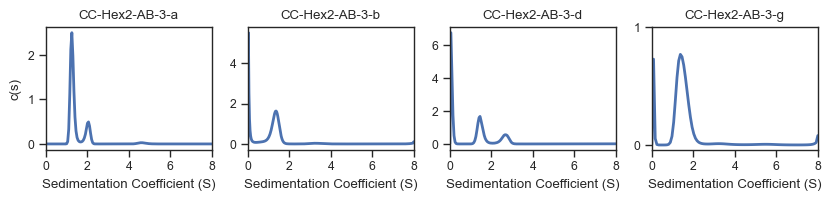

In [43]:
sv_data_paths = sorted(data_dir.glob('*/04_sv/repeat_1'))

sv_lst = []

for p in sv_data_paths:
    peptide = p.parent.parent.stem
    auc_sv_data, _, sv_parms = AUCanalysis.parse_sv(p, np.mean([2543.8, 2515.1]))
    auc_sv_data['peptide'] = "CC-Hex2-AB-3-"+peptide[-1]
    sv_lst.append(auc_sv_data)

sv_df = pd.concat(sv_lst, ignore_index=True)

sns.set(rc={"font.family":"Arial"}, style='ticks', context='paper')

g = sns.FacetGrid(
    data=sv_df.query('peptide != "CC-Hex2-AB-3-c"'),
    col='peptide',
    col_wrap=4,
    height=6.3/3,
    aspect=1,
    sharey=False
)

g.map(sns.lineplot,'Sedimentation Coefficient (S)', 'c(s)', lw=2)
g.set(xlim=[0,8])
g.set_titles(col_template="{col_name}")

g.axes[-1].set(yticks=[0,1])

sns.despine(right=False, top=False)
plt.tight_layout()
plt.savefig(figure_dir / 'S09/S9a.svg', transparent=True, format='svg')


## FigS10 (SE plots)

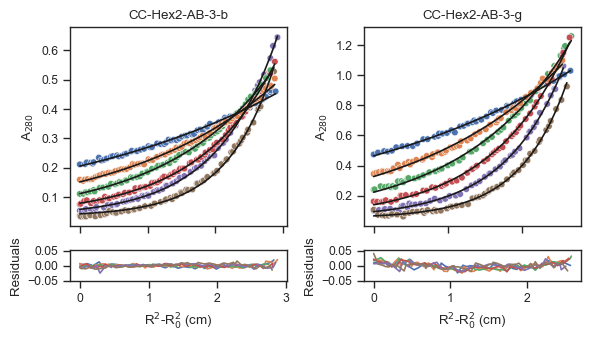

In [28]:
se_csv_paths = [
    data_dir / 'CC-Hex2-AB-3-b/05_se/repeat_1/221118_CC-Hex2-AB-3-b_SE_tidy.csv',
    data_dir / 'CC-Hex2-AB-3-g/05_se/repeat_1/220610_CC-Hex2-AB-3-g_SE_tidy.csv'
]

se_fit_axes = [plt.subplot2grid((5,2),(0,col), rowspan=4) for col in range(2)]
res_axes = [plt.subplot2grid((5,2),(4,col), rowspan=4) for col in range(2)]

channels = [2, 1]

sns.set(rc={'figure.figsize':[6,3.5], "font.family":"Arial"}, style='ticks', context='paper')

for csv_path, fit_ax, res_ax, channel in zip(se_csv_paths, se_fit_axes, res_axes, channels):

    df_tidy = pd.read_csv(csv_path)
    df_tidy['speed'] = df_tidy['speed'].astype('str')

    sns.lineplot(
        data=df_tidy.query(f'data_type=="fit" and channel == "channel_{channel}"'),
        x='radius',
        y='ab',
        ax=fit_ax,
        hue='speed',
        palette=['k']*len(df_tidy['speed'].unique()),
        legend=None
    )

    sns.scatterplot(
        data=df_tidy.query(f'data_type=="raw" and channel == "channel_{channel}"'),
        x='radius',
        y='ab',
        ax=fit_ax,
        hue='speed',
        legend=None
    )

    fit_ax.set_ylabel(r'A$_{280}$')
    fit_ax.set_xlabel('')

    assembly = re.search('(CC-Hex2-AB-3-[bg])', csv_path.stem).group(1)
    fit_ax.set_title(assembly)
    fit_ax.set_xticklabels([])

    sns.lineplot(
        data=df_tidy.query(f'data_type=="res" and channel == "channel_{channel}" and ab < 0.4'),
        x='radius',
        y='ab',
        ax=res_ax,
        hue='speed',
        legend=None
    )
    
    res_ax.set_ylabel(r'Residuals')
    res_ax.set_xlabel(r'R$^2$-R$^2_0$ (cm)')
    res_ax.set_ylim(-0.05+-0.05*0.05, 0.05+0.05*0.05)

plt.tight_layout()
plt.savefig(figure_dir / 'S10.svg', transparent=True, format='svg')

## FigS11 (DPH binding)

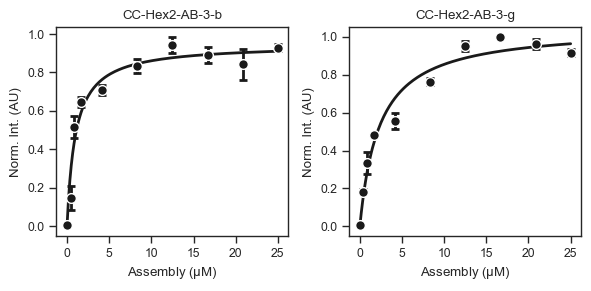

In [23]:
dph_csv_paths = [
    data_dir / 'CC-Hex2-AB-3-b/06_dph/20230915_2-5_150uM_CC-Hex2-AB-3-b_HBS_5pc_DMSO_1uM_DPH_t2_rep1.csv',
    data_dir / 'CC-Hex2-AB-3-g/06_dph/20230915_2-5_150uM_CC-Hex2-AB-3-g_HBS_5pc_DMSO_1uM_DPH_t2_rep1.csv'
]

dph_json_paths = [
    data_dir / 'CC-Hex2-AB-3-b/06_dph/20230915_2-5_150uM_CC-Hex2-AB-3-b_HBS_5pc_DMSO_1uM_DPH_t2_rep1.json',
    data_dir / 'CC-Hex2-AB-3-g/06_dph/20230915_2-5_150uM_CC-Hex2-AB-3-g_HBS_5pc_DMSO_1uM_DPH_t2_rep1.json'
]


axes = [plt.subplot2grid((1,2), (0,col)) for col in range(2)]

for csv_path, json_path, ax in zip(dph_csv_paths, dph_json_paths, axes):

    dph_data = pd.read_csv(csv_path)
    x_raw = dph_data.groupby('conc_uM')['conc_uM'].mean()
    y_raw = dph_data.groupby('conc_uM')['norm_int_AU'].mean()
    yerr = dph_data.groupby('conc_uM')['norm_int_AU'].std()

    with json_path.open() as f:
        dph_params = json.load(f)

    sns.set(rc={'figure.figsize':[6,3], "font.family":"Arial"}, style='ticks', context='paper')


    x_values = np.linspace(0, max(dph_data['conc_uM']), 151)
    y_values = DPHBindingAnalysis.single_site(x_values, *dph_params['fit_metrics']['params'])

    ax.errorbar(
        x_raw,
        y_raw,
        yerr=yerr,
        fmt='o',
        label='Data',
        color='k',
        mec='white',
        ms=7,
        capsize=3,
        elinewidth=2,
        capthick=2
    )
    
    ax.plot(x_values, y_values, label='Fit', linewidth=2, color='k')
    ax.set(
        xticks=np.linspace(0,150, 6),
        xlabel=r'Assembly ($\regular{\mu}$M)',
        ylabel='Norm. Int. (AU)',
        xticklabels=[int(x/6) for x in np.linspace(0,150, 6)]
    )

    assembly = re.search('(CC-Hex2-AB-3-[bg])', csv_path.stem).group(1)

    ax.set_title(assembly)

plt.tight_layout()
plt.savefig(figure_dir / 'S11.svg', format='svg', transparent=True);

## FigS12 (AF3 results)

In [3]:
# get files 
json_paths = [
    data_dir / 'CC-Hex2-AB-3-b/08_af3/fold_CC-Hex2-AB-3-b_full_data_0.json',
    data_dir / 'CC-Hex2-AB-3-c/08_af3/fold_CC-Hex2-AB-3-c_full_data_0.json',
    data_dir / 'CC-Hex2-AB-3-g/08_af3/fold_CC-Hex2-AB-3-g_full_data_0.json'
]
cif_paths = [
    data_dir / 'CC-Hex2-AB-3-b/08_af3/fold_CC-Hex2-AB-3-b_model_0.cif',
    data_dir / 'CC-Hex2-AB-3-c/08_af3/fold_CC-Hex2-AB-3-c_model_0.cif',
    data_dir / 'CC-Hex2-AB-3-g/08_af3/fold_CC-Hex2-AB-3-g_model_0.cif'
]

letters1 = ['b', 'e', 'h']
letters2 = ['c', 'f', 'i']

af3_plot_info = zip(json_paths, cif_paths, letters1, letters2)

for json_path, cif_path, letter1, letter2 in af3_plot_info:

    # parse the data
    pae_data, plddt_data = AF3Analysis.parse_AF3_scores(json_path, cif_path)

    # ca-plddt plot
    sns.set(rc={'figure.figsize':[2.1,2.1], "font.family":"Arial"}, style='ticks', context='paper')
    AF3Analysis.AF3_plddt_plot(plddt_data)
    sns.despine(top=False, right=False)
    plt.tight_layout()
    plt.savefig(figure_dir / f'S12/S12{letter1}.png', format='png', transparent=True, dpi=300)
    plt.close()  # Clear the figure to prepare for the next plot

    # pae plot
    sns.set(rc={'figure.figsize':[6.3/3,6.3/2.5], "font.family":"Arial"}, style='ticks', context='paper')
    AF3Analysis.AF3_pae_plot(pae_data)
    sns.despine(top=False, right=False)
    plt.savefig(figure_dir / f'S12/S12{letter2}.png', format='png', transparent=True, dpi=300)
    plt.close()
